# EDA Hugging Face Dataset

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import ast

## Data Dictionary
<details>
<summary>Click to expand</summary>

| Column Name     | Description                                                                                     |
|-----------------|-------------------------------------------------------------------------------------------------|
| text            | The text data in each row.                                                                     |
| labels          | The labels associated with each text (e.g., toxic, non-toxic).                                  |
| encoded_labels  | Encoded version of the labels for machine learning models.                                      |
| text_length(added)     | The length of each text in the `text` column, calculated as the number of characters in the text.|
| labels_list(added)     |  Parsed lists of labels                 |

</details>


Data consists of three columns stored in parquet files: 
- encoded labels sotred as strings in single column, will have to be converted to binary array for ML. 

In [18]:
def read_parquet_files(file_path_pattern):
    dfs =[]
    #glob finds all path names matching specified pattern
    for file_name in glob.glob(file_path_pattern):
        df =pd.read_parquet(file_name, engine='pyarrow')
        dfs.append(df)
    return pd.concat(dfs, ignore_index =True)

## Train Data Set

In [19]:
data = read_parquet_files('../data/hugging/train-*.parquet') #use wildcard -* to identify pattern

In [20]:
data.head()

,text,labels,encoded_labels
0,Football positions \n\nHi Mehudson. When you'...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Thank you SO MUCH for your Nazi-like oversight...,"[toxic, profane, insult]","[1, 1, 1, 0, 0, 0, 0, 0, 0]"
2,Darkwind \n Stick it up your arse you offensi...,"[toxic, profane]","[1, 1, 0, 0, 0, 0, 0, 0, 0]"
3,Message from you to an IP \n\nI received a mes...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Misleading and inappropriate citations Used,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6344950 entries, 0 to 6344949
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   text            object
 1   labels          object
 2   encoded_labels  object
dtypes: object(3)
memory usage: 145.2+ MB


In [22]:
data.isnull().sum()

text              0
labels            0
encoded_labels    0
dtype: int64

### Text Length

In [23]:
#add column with text length
data['text_length'] = data['text'].apply(len)

In [24]:
data.head(3)

,text,labels,encoded_labels,text_length
0,Football positions \n\nHi Mehudson. When you'...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",324
1,Thank you SO MUCH for your Nazi-like oversight...,"[toxic, profane, insult]","[1, 1, 1, 0, 0, 0, 0, 0, 0]",272
2,Darkwind \n Stick it up your arse you offensi...,"[toxic, profane]","[1, 1, 0, 0, 0, 0, 0, 0, 0]",99


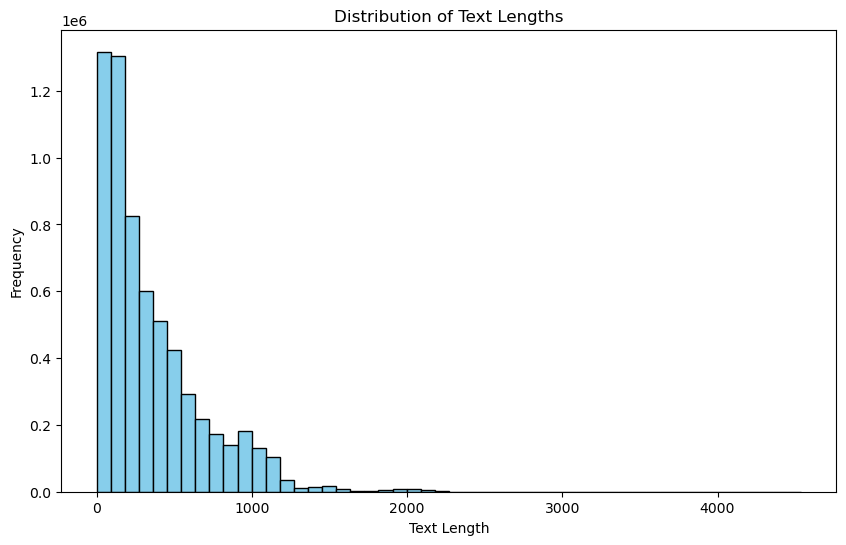

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(data['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()


### Label Distribution and Class Imbalance

In [32]:
data.head()

,text,labels,encoded_labels,text_length,labels_list
0,Football positions \n\nHi Mehudson. When you'...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",324,[]
1,Thank you SO MUCH for your Nazi-like oversight...,"[toxic, profane, insult]","[1, 1, 1, 0, 0, 0, 0, 0, 0]",272,[]
2,Darkwind \n Stick it up your arse you offensi...,"[toxic, profane]","[1, 1, 0, 0, 0, 0, 0, 0, 0]",99,[]
3,Message from you to an IP \n\nI received a mes...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",292,[]
4,Misleading and inappropriate citations Used,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",43,[]


In [109]:
#handle empty strings of labels
def safe_literal_eval(x):
    try:
        if isinstance(x, str): 
            if x.startswith('[') and x.endswith(']'):
                return ast.literal_eval(x)
            else:
                return []
        elif isinstance(x, np.ndarray):
            return x.tolist()
        else:
            return []         
    except (SyntaxError, ValueError):
        return []

In [38]:
#ast.literal_eval convert string representation of labels to a list
data['labels_list'] = data['labels'].apply(safe_literal_eval) 
#flatten list
#first part iterate through rows, nested for; iterate through labels in row
all_labels = [label for labels_list in data['labels_list'] for label in labels_list]

#calculate distribution -> convert all_labels to a series to count
label_dist = pd.Series(all_labels).value_counts()

#count occurences of rows without labels
no_label_count = data['labels_list'].apply(lambda x: len(x) == 0).sum() # use lambda func. to count occurence where len of string =0

print("Label distribution:")
print(label_dist)
print("\nNumber of rows without labels:", no_label_count)


Label distribution:
toxic         568042
selfharm      247778
insult        237258
profane        51340
hate           49439
offensive      37329
threat          9065
sexual          8929
harassment      4072
Name: count, dtype: int64

Number of rows without labels: 5436491


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6344950 entries, 0 to 6344949
Data columns (total 5 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   text            object
 1   labels          object
 2   encoded_labels  object
 3   text_length     int64 
 4   labels_list     object
dtypes: int64(1), object(4)
memory usage: 242.0+ MB


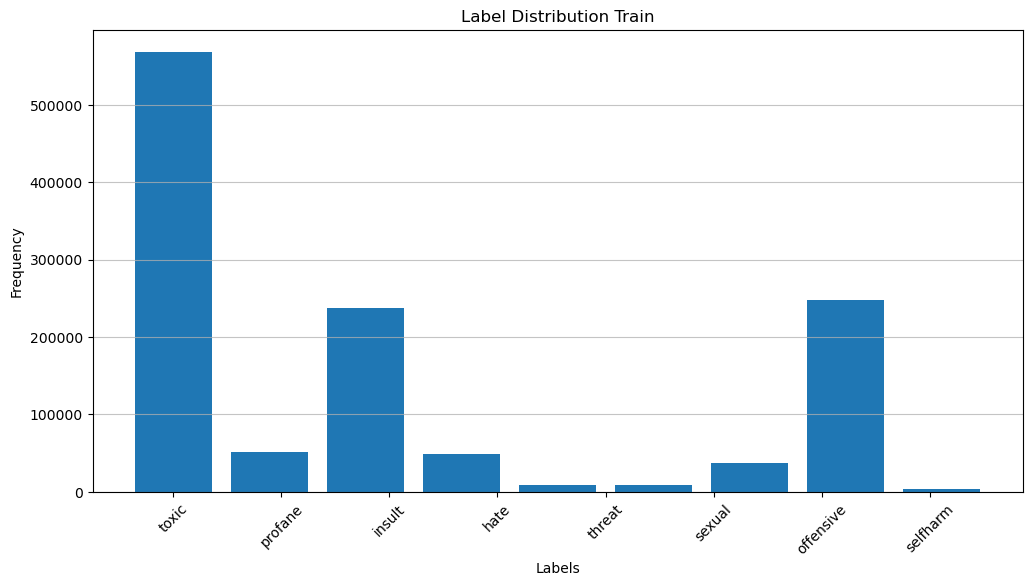

In [42]:
#flatten-> convert list of lists into single list (all_labels is flattened list variable)
# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(all_labels, bins=len(set(all_labels)), align='left', rwidth=0.8)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution Train')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()



Number of occurences of toxic: 568,042 and number of occurences of no label: 5,436,491 -> high class imbalance in dataset

In [112]:
# Calculate the percentage of 'toxic' labels in the dataset
total_samples = len(data)
toxic_count = label_dist.get('toxic', 0)  # Get count of 'toxic' labels or 0 if 'toxic' not found
toxic_percentage = (toxic_count / total_samples) * 100

print(f"Percentage of 'toxic' labels in the train dataset: {toxic_percentage:.2f}%")

Percentage of 'toxic' labels in the train dataset: 8.95%


**Co Occurence** For this analysis will look at co-occurance of up to 2 labels

In [87]:
from itertools import combinations
from sklearn.preprocessing import MultiLabelBinarizer


In [85]:
data['encoded_labels'].head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0]
1    [1, 1, 1, 0, 0, 0, 0, 0, 0]
2    [1, 1, 0, 0, 0, 0, 0, 0, 0]
3    [0, 0, 0, 0, 0, 0, 0, 0, 0]
4    [0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: encoded_labels, dtype: object

In [89]:
#one hot encode labels use mlb, use column 'labels_list'
mlb=MultiLabelBinarizer()
one_hot_labels = mlb.fit_transform(data['labels_list'])
#create a one hot encoded df
one_hot_df = pd.DataFrame(one_hot_labels, columns =mlb.classes_)

In [92]:
one_hot_df.head()

,harassment,hate,insult,offensive,profane,selfharm,sexual,threat,toxic
0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,1
2,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0


In [91]:
#get count of co occurrence of other labels with toxic 
label_to_check = 'toxic'
#use .dot (dot product -> results in new matrix(df) calculate dot product of toxic column with remaining cols.)
co_occur_toxic = one_hot_df[label_to_check].dot(one_hot_df.drop(label_to_check, axis=1))
print(co_occur_toxic)

harassment         0
hate           21718
insult        218898
offensive          0
profane        35545
selfharm           0
sexual          7308
threat          8121
Name: toxic, dtype: int64


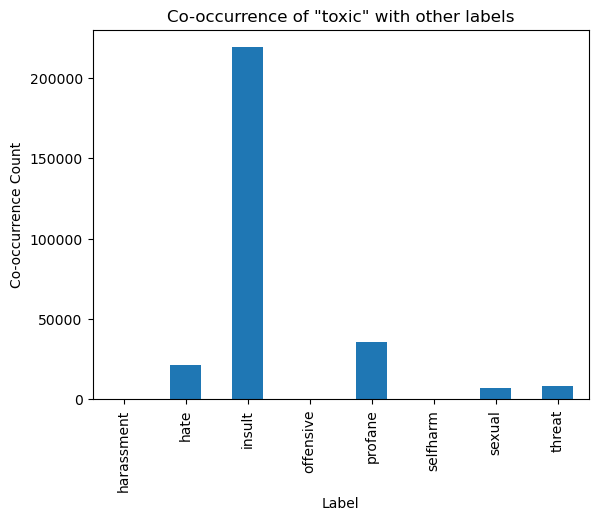

In [94]:
co_occur_toxic.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Co-occurrence Count')
plt.title('Co-occurrence of "toxic" with other labels')
plt.show()

In looking at co-occurence of other labels with the label toxic, insult appears the most with toxic. This is followed by 'profane', 'hate', 'sexual' and 'threat' however insult co-occurs by far the most with the label toxic. 

### Languages in Text

In [76]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from joblib import Parallel, delayed

 **System Specifications and Parallelization**

- **Model Name:** Mac mini
- **Chip:** Apple M2
- **Total Number of Cores:** 8 (4 performance and 4 efficiency)
- **Memory:** 16 GB


**Parallization**
n_jobs = 3


In [74]:
def detect_language(text):
    try:
        if len(text) > 3: #algorithm cannot detect language with less than 3 characters
            return detect(text)
        else:
            return "unknown"
    except LangDetectException:
        return "unknown"

In [78]:
data['language'] = Parallel(n_jobs=3)(delayed(detect_language)(x) for x in data['text'])

In [79]:
data.head()

,text,labels,encoded_labels,text_length,labels_list,language
0,Football positions \n\nHi Mehudson. When you'...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",324,[],en
1,Thank you SO MUCH for your Nazi-like oversight...,"[toxic, profane, insult]","[1, 1, 1, 0, 0, 0, 0, 0, 0]",272,"[toxic, profane, insult]",en
2,Darkwind \n Stick it up your arse you offensi...,"[toxic, profane]","[1, 1, 0, 0, 0, 0, 0, 0, 0]",99,"[toxic, profane]",en
3,Message from you to an IP \n\nI received a mes...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",292,[],en
4,Misleading and inappropriate citations Used,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",43,[],en


Note: the way language of text was added if text less than 3 characters then language is unknown. 

In [82]:
data['language'].value_counts()

language
en         2541753
es         1956756
fr         1697795
pt           20810
ca           14841
it           13552
de           12658
unknown       8033
af            7650
nl            7046
so            6586
da            5520
tl            5513
id            5394
cy            4863
no            4845
ro            4785
et            3265
hu            2256
sl            2182
sv            2105
fi            2020
vi            1683
tr            1664
sw            1482
pl            1449
lt            1439
hr            1419
sk            1128
cs             789
sq             722
lv             701
uk             594
hi             340
ar             225
bn             186
ru             150
fa             139
el             135
bg             127
ko             114
ta              46
he              42
mk              39
ur              20
mr              18
kn              18
ml              17
th              14
ne              11
gu               6
pa               3
te 

English is the highest occuring language in the dataset, followed by spanish and french. 

**Description of Languages**
<details>
<summary>Click to expand</summary>

- en: English
- es: Spanish
- fr: French
- pt: Portuguese
- ca: Catalan
- it: Italian
- de: German
- unknown: Unknown
- af: Afrikaans
- nl: Dutch
- so: Somali
- da: Danish
- tl: Tagalog
- id: Indonesian
- cy: Welsh
- no: Norwegian
- ro: Romanian
- et: Estonian
- hu: Hungarian
- sl: Slovenian
- sv: Swedish
- fi: Finnish
- vi: Vietnamese
- tr: Turkish
- sw: Swahili
- pl: Polish
- lt: Lithuanian
- hr: Croatian
- sk: Slovak
- cs: Czech
- sq: Albanian
- lv: Latvian
- uk: Ukrainian
- hi: Hindi
- ar: Arabic
- bn: Bengali
- ru: Russian
- fa: Persian
- el: Greek
- bg: Bulgarian
- ko: Korean
- ta: Tamil
- he: Hebrew
- mk: Macedonian
- ur: Urdu
- mr: Marathi
- kn: Kannada
- ml: Malayalam
- th: Thai
- ne: Nepali
- gu: Gujarati
- pa: Punjabi
- te: Telugu

</details>


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6344950 entries, 0 to 6344949
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   text            object
 1   labels          object
 2   encoded_labels  object
 3   text_length     int64 
 4   labels_list     object
 5   language        object
dtypes: int64(1), object(5)
memory usage: 290.4+ MB


**Occurence of label 'toxic' by language**

In [98]:
#occurence of label toxic by language 
exploded_data = data.explode('labels_list')

# Group by 'language' and 'labels_list', then count the occurrences of 'toxic' in each group
grouped_data = exploded_data.groupby(['language', 'labels_list'])['labels_list'].apply(lambda x: (x == 'toxic').sum())

# Reset the index to get a DataFrame with 'toxic_count' for each language and label
toxic_count_by_language = grouped_data.reset_index(name='toxic_count')

print(toxic_count_by_language)

    language labels_list  toxic_count
0         af  harassment            0
1         af        hate            0
2         af      insult            0
3         af   offensive            0
4         af     profane            0
..       ...         ...          ...
318       vi   offensive            0
319       vi     profane            0
320       vi    selfharm            0
321       vi      sexual            0
322       vi       toxic          271

[323 rows x 3 columns]


In [101]:
tot_tc_by_language = toxic_count_by_language.groupby('language')['toxic_count'].sum().reset_index(name='total_toxic_count')
print(tot_tc_by_language)

   language  total_toxic_count
0        af                415
1        ar                  0
2        bg                  3
3        bn                  4
4        ca               1274
5        cs                 44
6        cy                344
7        da                183
8        de               2141
9        el                  0
10       en             326820
11       es             115147
12       et                268
13       fa                  0
14       fi                141
15       fr             114311
16       he                  0
17       hi                  3
18       hr                123
19       hu                177
20       id                350
21       it               1224
22       lt                104
23       lv                 61
24       mk                  0
25       ml                  0
26       nl                296
27       no                289
28       pl                 91
29       pt               1895
30       ro                543
31      

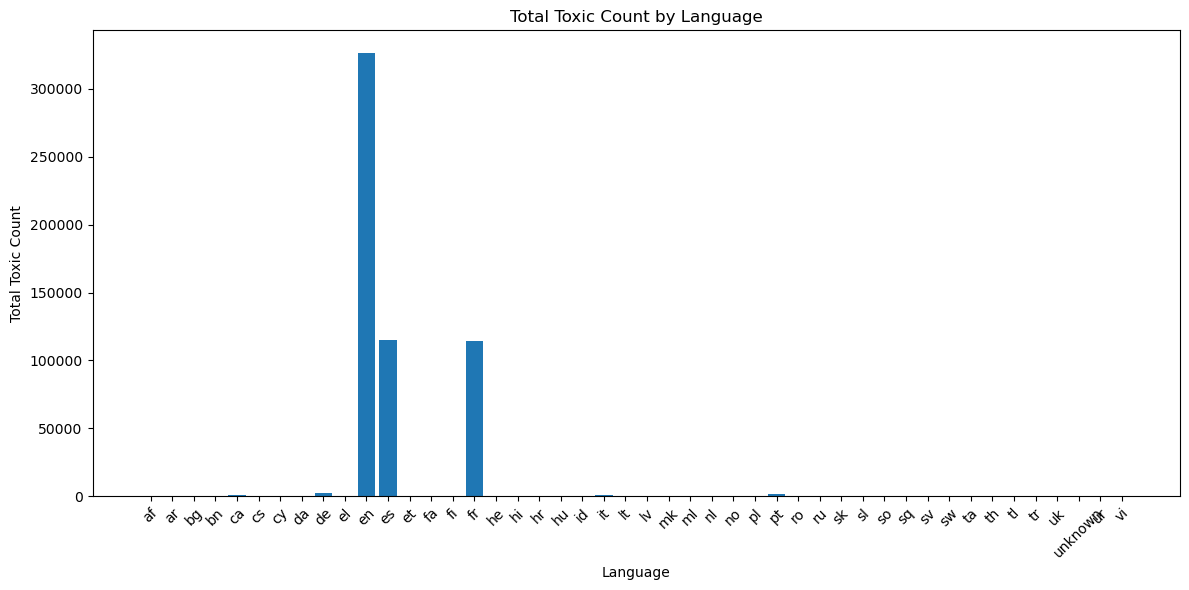

In [102]:
plt.figure(figsize=(12, 6))
plt.bar(tot_tc_by_language['language'], tot_tc_by_language['total_toxic_count'])
plt.xlabel('Language')
plt.ylabel('Total Toxic Count')
plt.title('Total Toxic Count by Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Validation set

In [103]:
df_val = read_parquet_files('../data/hugging/validation-*.parquet')

In [104]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710497 entries, 0 to 710496
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            710497 non-null  object
 1   labels          710497 non-null  object
 2   encoded_labels  710497 non-null  object
dtypes: object(3)
memory usage: 16.3+ MB


In [105]:
df_val['text_length'] = df_val['text'].apply(len)

In [106]:
df_val.head(2)

,text,labels,encoded_labels,text_length
0,Go ahead and merge what you think is necessary...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",101
1,"""\n\n Merging Red Hand of Doom and Reliability...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",1625


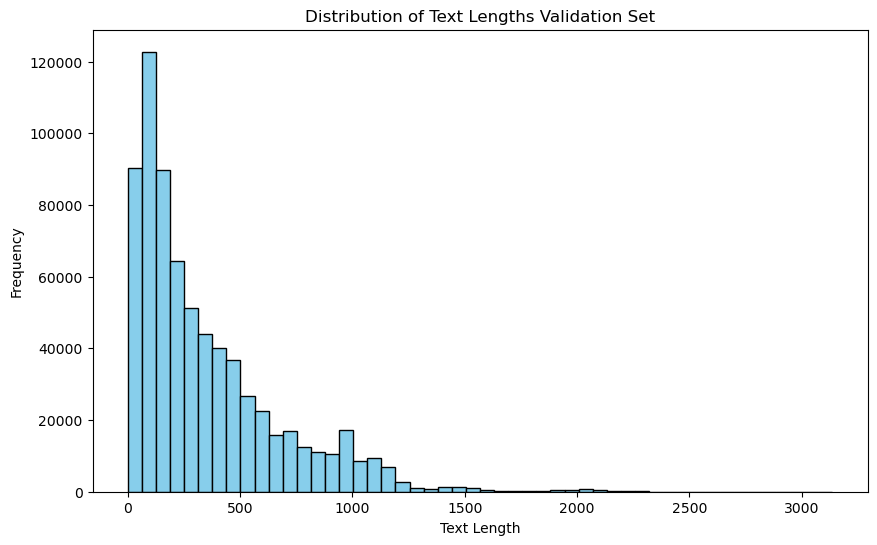

In [108]:
#text length distribution in val set
plt.figure(figsize=(10, 6))
plt.hist(df_val['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths Validation Set')
plt.show()


In [110]:
#ast.literal_eval convert string representation of labels to a list
df_val['labels_list'] = df_val['labels'].apply(safe_literal_eval) 
#flatten list
#first part iterate through rows, nested for; iterate through labels in row
all_labels_val = [label for labels_list in df_val['labels_list'] for label in labels_list]

#calculate distribution -> convert all_labels to a series to count
label_dist_val = pd.Series(all_labels_val).value_counts()

#count occurences of rows without labels
no_label_count_val = df_val['labels_list'].apply(lambda x: len(x) == 0).sum() # use lambda func. to count occurence where len of string =0

print("Label distribution:")
print(label_dist_val)
print("\nNumber of rows without labels:", no_label_count_val)

Label distribution:
toxic         63233
selfharm      29430
insult        26564
profane        5640
hate           5409
offensive      4190
threat         1050
sexual         1004
harassment      465
Name: count, dtype: int64

Number of rows without labels: 607497


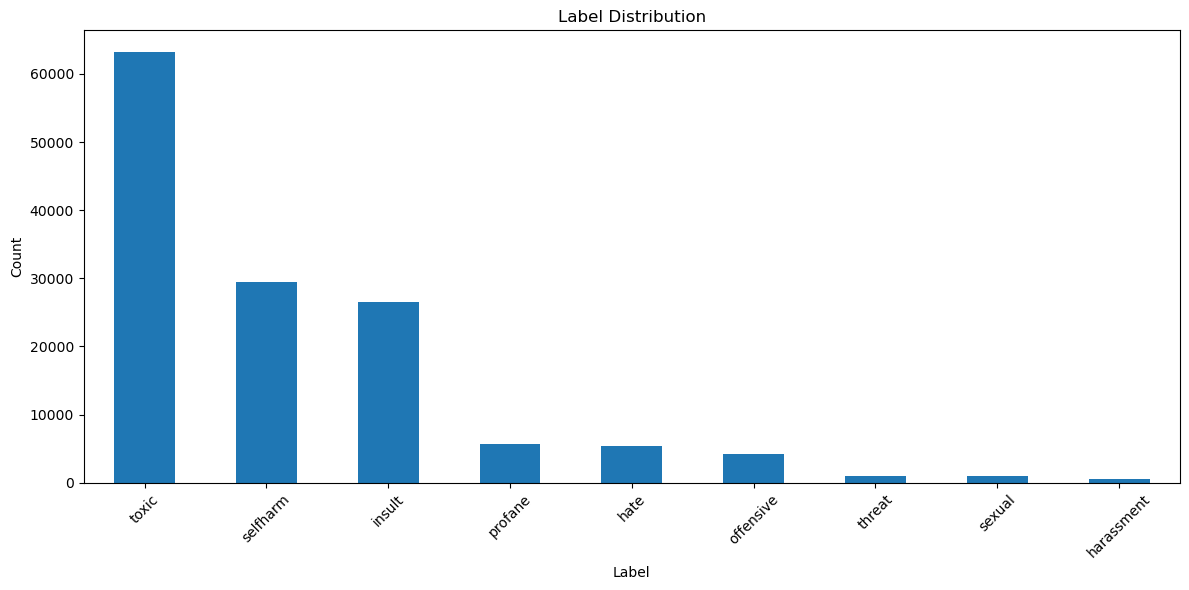

Percentage of 'toxic' labels in the dataset: 8.90%


In [111]:
plt.figure(figsize=(12, 6))
label_dist_val.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate the percentage of 'toxic' labels in the dataset
total_samples_val = len(df_val)
toxic_count_val = label_dist_val.get('toxic', 0)  # Get count of 'toxic' labels or 0 if 'toxic' not found
toxic_percentage_val = (toxic_count_val / total_samples_val) * 100

print(f"Percentage of 'toxic' labels in the dataset: {toxic_percentage_val:.2f}%")

**Summary Distributions:** 
Similar distribution to train set of toxic label,percentage of toxic labels in train set; 8.95%. Distributions of other labels slightly different from train set, however toxic is the most prevalent. Similar Distriubtion of text lengths between train and validation. 

If using Hugging face dataset, language column can be added to validation set, also possibly could combine validation data obtained from hugging face with train to get one working dataset and perform a train test split for modelling. 

### Word Frequency

In [43]:
from nltk.tokenize import word_tokenize
from collections import Counter